# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gzip
import shutil
import os
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire_nick as an
import prepare_nick as pn
import wrangle as w

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = w.wrangle_df()
df.head()

Using cached CSV


,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0


In [3]:
df.shape

(6893, 36)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6893 entries, 5 to 443319
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 6893 non-null   object 
 1   success               6893 non-null   int64  
 2   success_rating        6893 non-null   float64
 3   genres                6891 non-null   object 
 4   cast_actor_1          6893 non-null   object 
 5   cast_actor_2          6893 non-null   object 
 6   cast_actor_3          6893 non-null   object 
 7   total_n_cast          6893 non-null   float64
 8   budget                6893 non-null   float64
 9   revenue               6893 non-null   float64
 10  profit_amount         6893 non-null   float64
 11  vote_average          6893 non-null   float64
 12  vote_count            6893 non-null   float64
 13  production_companies  6893 non-null   object 
 14  production_countries  6893 non-null   object 
 15  overview           

In [5]:
df.budget.astype(int)
df.describe()

,success,success_rating,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,popularity,runtime,profitable,release_year,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
count,6893.000000,6893.000000,6893.000000,6.893000e+03,6.893000e+03,6.893000e+03,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000
mean,0.388365,9.681530,22.313361,2.712073e+07,7.356855e+07,4.644782e+07,6.259234,599.120847,8.986854,108.396489,0.407660,1999.471058,0.156536,0.103583,0.498767,0.104744,0.194545,0.261860,0.152909,0.351081,0.052372,0.242710,0.078921,0.087335,0.017844
std,0.487414,21.848662,19.102737,3.612200e+07,1.506686e+08,1.262272e+08,0.938088,1136.481658,12.449917,20.782590,0.491435,15.708290,0.363389,0.304741,0.500035,0.306245,0.395879,0.439679,0.359926,0.477343,0.222792,0.428752,0.269634,0.282346,0.132395
min,0.000000,0.000000,3.000000,1.020000e+06,1.000000e+00,-1.657101e+08,0.000000,0.000000,0.000578,0.000000,0.000000,1915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.989076,12.000000,1.000000e+07,3.442853e+06,-7.953834e+06,5.700000,54.000000,4.743517,95.000000,0.000000,1992.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.330402,17.000000,1.000000e+07,1.968292e+07,4.917287e+06,6.300000,193.000000,7.805145,105.000000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,10.588779,25.000000,3.000000e+07,7.415135e+07,4.500000e+07,6.900000,595.000000,11.174041,118.000000,1.000000,2011.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,667.333333,313.000000,3.800000e+08,2.787965e+09,2.550965e+09,10.000000,14075.000000,547.488298,338.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df['success_rating'] = (df['revenue']/(df['budget'] * 2)) * df['vote_average']

In [7]:
df.head(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0


In [8]:
df[df.success == 1].cast_actor_1.value_counts()

Tom Cruise                  27
Tom Hanks                   27
Sylvester Stallone          21
Clint Eastwood              19
Adam Sandler                17
Denzel Washington           17
Mel Gibson                  16
Bruce Willis                16
Jim Carrey                  16
Johnny Depp                 15
Sean Connery                15
Robert De Niro              15
Meryl Streep                14
Will Smith                  14
Mark Wahlberg               14
Ben Stiller                 14
Robin Williams              13
Paul Newman                 13
Brad Pitt                   13
John Travolta               13
Keanu Reeves                13
Leonardo DiCaprio           12
George Clooney              12
Harrison Ford               12
Kevin Costner               12
Matt Damon                  12
Nicolas Cage                12
Arnold Schwarzenegger       12
Julia Roberts               11
Jack Nicholson              11
Al Pacino                   11
Steve Martin                11
Eddie Mu

In [9]:
df.groupby('release_year').success.sum().tail(15)

release_year
2003     66
2004     75
2005     78
2006     87
2007     93
2008     94
2009     94
2010     98
2011    106
2012     98
2013    121
2014    108
2015    112
2016    101
2017     41
Name: success, dtype: int64

<AxesSubplot:xlabel='id'>

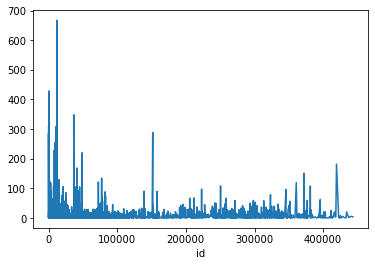

In [10]:
df.success_rating.plot()

In [11]:
df['success'] = (df['success_rating'] > 6.5) * 1

In [12]:
df.sample(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14484,Body Shots,0,0.056375,Drama Romance,Jerry O'Connell,Amanda Peet,Sean Patrick Flanery,31.0,10000000.0,239894.0,-9760106.0,4.7,21.0,NewLineCinema Colomby/KeatonProductions,UnitedStatesofAmerica,The Los Angeles club scene is a place of booze...,4.607583,106.0,0,1999-10-07,1999,tt0172627,NewLineCinema,0,0,1,0,1,0,0,0,0,0,0,0,0
11326,Tommy,1,22.263491,Drama Music,Oliver Reed,Ann-Margret,Roger Daltrey,15.0,5000000.0,34251525.0,29251525.0,6.5,69.0,ColumbiaPictures HemdaleFilm RobertStigwoodOrg...,UnitedKingdom,"A psychosomatically deaf, dumb and blind boy b...",6.335814,111.0,1,1975-03-19,1975,tt0073812,ColumbiaPictures,0,0,1,0,0,0,0,0,0,0,0,0,0
32511,"Police, Adjective",0,0.135225,Drama Foreign,Dragoș Bucur,Vlad Ivanov,Irina Saulescu,15.0,1089360.0,48298.0,-1041062.0,6.1,14.0,HBO 42KmFilm PeriscopFilm Racova RazaStudio,Romania,A cop named Cristi must go undercover to trail...,0.663231,115.0,0,2009-05-15,2009,tt1337051,HBO,0,0,1,0,0,0,0,0,0,0,0,0,0
12150,Sea of Love,1,19.549809,Drama Crime Mystery,Al Pacino,Ellen Barkin,John Goodman,12.0,19000000.0,110879513.0,91879513.0,6.7,144.0,UniversalPicturesCorporation,UnitedStatesofAmerica,Seen-it-all New York detective Frank Keller is...,9.801967,113.0,1,1989-09-15,1989,tt0098273,UniversalPicturesCorporation,0,0,1,0,0,0,1,0,0,0,1,0,0
26515,Pumpkinhead,0,3.696363,Fantasy Horror,Lance Henriksen,Jeff East,John D'Aquino,20.0,3500000.0,4385516.0,885516.0,5.9,108.0,DeLaurentiisEntertainmentGroup(DEG) LionFilms,UnitedStatesofAmerica,A man conjures up a gigantic vengeance demon c...,11.841506,86.0,0,1988-06-09,1988,tt0095925,DeLaurentiisEntertainmentGroup(DEG),0,1,0,0,0,0,0,0,0,0,0,1,0


In [13]:
def train_validate_test_split(df):
    ''' 
    This function takes in a dataframe and splits it 80:20.  The 20% will be our testing datafrme for our final model.  The 80% will be split a second time (70:30), creating our final training dataframe and a dataframe to validate our model with before testing.  Leaving us we a Train (56%), Validate(24%) and Test (20%) Dataframe from our original data (100%)
    '''
    
    train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)
    
    
    train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)
    
    
    return train, validate, test


train, validate, test = train_validate_test_split(df)

train.shape, validate.shape, test.shape

((3859, 36), (1655, 36), (1379, 36))

# Scaling and One Hot Encoding

In [14]:
# Scaling
# Columns to be scaled: 
scaler = MinMaxScaler()


In [15]:
# One Hot Encode for Genres

# df['is_genre_adventure'] = df.genres.apply(lambda genre_list: 'Adventure' in genre_list)
# df['is_genre_horror'] = df.genres.apply(lambda genre_list: 'Horror' in genre_list)
# df['is_genre_drama'] = df.genres.apply(lambda genre_list: 'Drama' in genre_list)
# df['is_genre_scifi'] = df.genres.apply(lambda genre_list: 'Science' in genre_list)
# df['is_genre_romance'] = df.genres.apply(lambda genre_list: 'Romance' in genre_list)
# df['is_genre_thriller'] = df.genres.apply(lambda genre_list: 'Thriller' in genre_list)
# df['is_genre_crime'] = df.genres.apply(lambda genre_list: 'Crime' in genre_list)
# df['is_genre_comedy'] = df.genres.apply(lambda genre_list: 'Comedy' in genre_list)
# df['is_genre_animation'] = df.genres.apply(lambda genre_list: 'Animation' in genre_list)
# df['is_genre_action'] = df.genres.apply(lambda genre_list: 'Action' in genre_list)
# df['is_genre_mystery'] = df.genres.apply(lambda genre_list: 'Mystery' in genre_list)
# df['is_genre_fantasy'] = df.genres.apply(lambda genre_list: 'Fantasy' in genre_list)
# df['is_genre_documentary'] = df.genres.apply(lambda genre_list: 'Documentary' in genre_list)

In [16]:
# One Hot Encode Production Company


In [17]:
df.production_company.value_counts()

UniversalPictures                                                  398
ParamountPictures                                                  386
TwentiethCenturyFoxFilmCorporation                                 291
ColumbiaPictures                                                   232
NewLineCinema                                                      184
WarnerBros.                                                        162
WaltDisneyPictures                                                 145
Metro-Goldwyn-Mayer(MGM)                                           107
ColumbiaPicturesCorporation                                        104
UnitedArtists                                                      101
MiramaxFilms                                                        96
TriStarPictures                                                     93
VillageRoadshowPictures                                             74
FoxSearchlightPictures                                              67
DreamW

In [18]:
# Variables for constructing models
x_train = train.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_train = train.success

x_validate = validate.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_validate = validate.success

x_test = test.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_test = test.success

In [19]:
train.success.value_counts()

0    2358
1    1501
Name: success, dtype: int64

In [20]:
# Now that our training sample is ready, lets set up a baseline accuracy to improve upon
train['baseline'] = 0

baseline_accuracy = (train.baseline == train.success).mean()
print(f'Our baseline accuracy is {baseline_accuracy: .2%}')


Our baseline accuracy is  61.10%


In [21]:
# # Random Forest #

# # Make the Model
# forest = RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1313)

# # Fit the Model
# forest.fit(x_train, y_train)

# # Use the Model
# y_pred = forest.predict(x_train)


# performance = classification_report(y_train, y_pred, output_dict=True)

# # Classification Report
# pd.DataFrame(performance).transpose()

In [22]:
# Logistic Regression

# Make the Model
logit = LogisticRegression(C=10, random_state=1313)

# Select the Features we want focused on
features = ['runtime', 'budget']

# Fit the Model
logit.fit(x_train[features], y_train)

# Predictions
y_pred = logit.predict(x_train[features])

# Model Score
m_score = logit.score(x_train[features], y_train)

performance = classification_report(y_train, y_pred, output_dict=True, zero_division=0)

# Classification Report
pd.DataFrame(performance).transpose()


,precision,recall,f1-score,support
0,0.611039,1.000000,0.758565,2358.000000
1,0.000000,0.000000,0.000000,1501.000000
accuracy,0.611039,0.611039,0.611039,0.611039
macro avg,0.305520,0.500000,0.379283,3859.000000
weighted avg,0.373369,0.611039,0.463513,3859.000000


### Test different target variables

In [23]:
df_copy = df.copy()

In [24]:
df_copy.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0


In [25]:
df_copy['success'] = (df_copy['success_rating'] > 6.5)
df_copy['success'].value_counts(normalize=True)

False    0.611635
True     0.388365
Name: success, dtype: float64

In [26]:
df_copy['success'] = (df_copy['success_rating'] > 7)
df_copy['success'].value_counts(normalize=True)

False    0.635137
True     0.364863
Name: success, dtype: float64

In [27]:
df_copy['success'] = (df_copy['success_rating'] > 7.5)
df_copy['success'].value_counts(normalize=True)

False    0.653562
True     0.346438
Name: success, dtype: float64

In [28]:
df_copy['success'] = (df_copy['success_rating'] > 8.5)
df_copy['success'].value_counts(normalize=True)

False    0.690556
True     0.309444
Name: success, dtype: float64

In [29]:
df_copy['success'] = (df_copy['success_rating'] > 9)
df_copy['success'].value_counts(normalize=True)

False    0.706514
True     0.293486
Name: success, dtype: float64

In [30]:
df_copy['success'] = (df_copy['success_rating'] > 10)
df_copy['success'].value_counts(normalize=True)

False    0.733788
True     0.266212
Name: success, dtype: float64

In [31]:
df_copy['success'] = (df_copy['success_rating'] > 12)
df_copy['success'].value_counts(normalize=True)

False    0.781082
True     0.218918
Name: success, dtype: float64

<AxesSubplot:xlabel='id'>

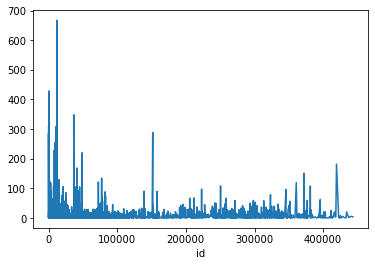

In [32]:
df_copy['success'] = (df_copy['success_rating'] > 6.5) * 1

df_copy.success_rating.plot()

In [33]:
# TAKEAWAYS/NOTES #
# Anything over 9 would need to have had either made more than double the budget, or get close to a perfect rating
# 

In [34]:
df[df.success == 1].total_n_cast.sort_values(ascending=False).head(15).mean()

178.53333333333333

In [35]:
df[df.success == 1].runtime.sort_values(ascending=False).head(10).mean()

234.9

In [36]:
df[df.success == 1].runtime.sort_values(ascending=False).head(50).mean()

195.34

In [37]:
df[df.success == 1].runtime.sort_values(ascending=False).head(100).mean()

181.11

# Dive Deeper
- Genre percentages
- Rule Sets for different movies/genres/production companies
- Insights gained from model

In [38]:
genre_list = ['is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary']

In [39]:
# how much of the data is adventure
df.is_genre_adventure.value_counts(normalize=True)

0    0.843464
1    0.156536
Name: is_genre_adventure, dtype: float64

In [40]:
df[df.success == 1].is_genre_adventure.value_counts(normalize=True)

0    0.803511
1    0.196489
Name: is_genre_adventure, dtype: float64

In [41]:
for genre in df[genre_list]:
    print(df[genre].value_counts(normalize=True))
    print('----------------------------')
    

0    0.843464
1    0.156536
Name: is_genre_adventure, dtype: float64
----------------------------
0    0.896417
1    0.103583
Name: is_genre_horror, dtype: float64
----------------------------
0    0.501233
1    0.498767
Name: is_genre_drama, dtype: float64
----------------------------
0    0.895256
1    0.104744
Name: is_genre_scifi, dtype: float64
----------------------------
0    0.805455
1    0.194545
Name: is_genre_romance, dtype: float64
----------------------------
0    0.73814
1    0.26186
Name: is_genre_thriller, dtype: float64
----------------------------
0    0.847091
1    0.152909
Name: is_genre_crime, dtype: float64
----------------------------
0    0.648919
1    0.351081
Name: is_genre_comedy, dtype: float64
----------------------------
0    0.947628
1    0.052372
Name: is_genre_animation, dtype: float64
----------------------------
0    0.75729
1    0.24271
Name: is_genre_action, dtype: float64
----------------------------
0    0.921079
1    0.078921
Name: is_genre_myste

In [42]:
for genre in df[genre_list]:
    print(df[df.success == 1][genre].value_counts(normalize=True))

0    0.803511
1    0.196489
Name: is_genre_adventure, dtype: float64
0    0.893911
1    0.106089
Name: is_genre_horror, dtype: float64
0    0.549122
1    0.450878
Name: is_genre_drama, dtype: float64
0    0.892043
1    0.107957
Name: is_genre_scifi, dtype: float64
0    0.80762
1    0.19238
Name: is_genre_romance, dtype: float64
0    0.737393
1    0.262607
Name: is_genre_thriller, dtype: float64
0    0.843482
1    0.156518
Name: is_genre_crime, dtype: float64
0    0.641016
1    0.358984
Name: is_genre_comedy, dtype: float64
0    0.932387
1    0.067613
Name: is_genre_animation, dtype: float64
0    0.738887
1    0.261113
Name: is_genre_action, dtype: float64
0    0.921554
1    0.078446
Name: is_genre_mystery, dtype: float64
0    0.901009
1    0.098991
Name: is_genre_fantasy, dtype: float64
0    0.991782
1    0.008218
Name: is_genre_documentary, dtype: float64


<AxesSubplot:>

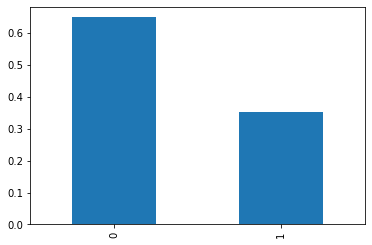

In [43]:
# how much of the data is comedy
df.is_genre_comedy.value_counts(normalize=True).plot.bar()

In [44]:
# how much of the data is drama
df.is_genre_drama.value_counts(normalize=True)

0    0.501233
1    0.498767
Name: is_genre_drama, dtype: float64

In [45]:
df.is_genre_horror.value_counts(normalize=True)

0    0.896417
1    0.103583
Name: is_genre_horror, dtype: float64

In [46]:
df.is_genre_thriller.value_counts(normalize=True)

0    0.73814
1    0.26186
Name: is_genre_thriller, dtype: float64

In [47]:
df.is_genre_action.value_counts(normalize=True)

0    0.75729
1    0.24271
Name: is_genre_action, dtype: float64

In [48]:
df[df.success == 1].budget.sort_values()

id
1939        1020000.0
33061       1100000.0
94329       1100000.0
11462       1103000.0
31526       1114000.0
56164       1180280.0
429         1200000.0
36685       1200000.0
845         1200000.0
176124      1200000.0
24128       1200000.0
24153       1200000.0
24924       1200000.0
16220       1200000.0
500         1200000.0
176         1200000.0
11319       1200000.0
43884       1200000.0
11219       1200000.0
20770       1200000.0
2671        1200000.0
17058       1202007.0
29244       1243000.0
43266       1250000.0
23730       1250000.0
9725        1250000.0
28580       1250000.0
19997       1250000.0
1643        1250000.0
14554       1271000.0
223         1288000.0
13986       1300000.0
25188       1300000.0
11951       1300000.0
192558      1300000.0
488         1300000.0
43881       1300000.0
103         1300000.0
31626       1333333.0
27367       1344000.0
100         1350000.0
19703       1400000.0
117691      1400000.0
521         1400000.0
16442       1400000.0
3309   

In [49]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0


In [50]:
df[df.success_rating != 0].success_rating.sort_values(ascending=True).head(5)

id
47168     2.450000e-07
274253    2.500000e-07
218275    2.800000e-07
45864     2.950000e-07
48787     3.200000e-07
Name: success_rating, dtype: float64

In [51]:
df['ROI'] = df.revenue / df.budget
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,ROI
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,1.075000
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,1.213694
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,70.490728
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,10.003570
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,12.326280


In [52]:
df['returns'] = pd.qcut(df.ROI, 4, labels=['low', 'avg', 'high', 'very high'])
df['budget_range'] = pd.qcut(df.budget, 5, labels=['low', 'avg', 'high', 'very high'], duplicates='drop')
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,1.075000,avg,low
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,1.213694,avg,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,12.326280,very high,very high


In [80]:
df[df.budget_range == 'low'].success.value_counts(normalize=True)

0    0.684152
1    0.315848
Name: success, dtype: float64

In [54]:
df[df.budget_range == 'low'].ROI.mean()

3.035437204467601

In [55]:
df[df.budget_range == 'very high'].budget.describe()

count    1.248000e+03
mean     8.861535e+07
std      4.692575e+07
min      4.060000e+07
25%      5.500000e+07
50%      7.225000e+07
75%      1.050000e+08
max      3.800000e+08
Name: budget, dtype: float64

In [56]:
df.ROI.sort_values().tail(10)

id
9427       73.671463
8346       73.748809
601        75.520507
176        86.593058
11224      90.893591
36685      94.076932
151743     94.545455
770       100.044115
408       124.242561
12092     190.666667
Name: ROI, dtype: float64

In [57]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,1.075000,avg,low
6,Judgment Night,0,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,1.213694,avg,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,12.326280,very high,very high


In [58]:
df[df.index == 12092]

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12092,Alice in Wonderland,1,667.333333,Animation Adventure Family Fantasy,Kathryn Beaumont,Verna Felton,Ed Wynn,15.0,3000000.0,572000000.0,569000000.0,7.0,1557.0,RKORadioPictures WaltDisneyProductions,UnitedStatesofAmerica,"On a golden afternoon, young Alice follows a W...",16.488937,75.0,1,1951-07-03,1951,tt0043274,RKORadioPictures,1,0,0,0,0,0,0,0,1,0,0,1,0,190.666667,very high,low


In [59]:
budget_tier = {'Budget Tier': ['Low', 'Avg', 'High', 'Very High'], 'Budget Range(Millions)': ['$1.02 - 8', '$8.05 - 15', '$15.05 - 36', '36.5 - 380'], 'Average ROI': ['2.975', '3.474', '2.656', '2.655'], 'Max ROI': ['190.66%', '75.52%', '29.91%', '17.5%']}

In [60]:
bt = pd.DataFrame(budget_tier)
bt = bt.groupby('Budget Tier', as_index=True)
bt.head()

,Budget Tier,Budget Range(Millions),Average ROI,Max ROI
0,Low,$1.02 - 8,2.975,190.66%
1,Avg,$8.05 - 15,3.474,75.52%
2,High,$15.05 - 36,2.656,29.91%
3,Very High,36.5 - 380,2.655,17.5%


## Budget Tier Breakdown

#### Low Budget

In [85]:
# Cast 1
df[df.budget_range == 'low'].cast_actor_1.value_counts().head(10)

Clint Eastwood    21
John Wayne        16
Chuck Norris      14
Ethan Hawke       12
Paul Newman       12
Woody Allen       12
Gene Hackman      11
Sean Connery      11
Robert Redford    11
Steve Martin      10
Name: cast_actor_1, dtype: int64

In [67]:
# Cast 2
df[df.budget_range == 'low'].cast_actor_2.value_counts().head()

Diane Keaton        8
Susan Sarandon      8
Jamie Lee Curtis    7
Eric Roberts        6
Jude Law            5
Name: cast_actor_2, dtype: int64

In [68]:
# Cast 3
df[df.budget_range == 'low'].cast_actor_3.value_counts().head()

Anna Faris        6
Jeremy Irons      5
Brian Dennehy     5
Susan Sarandon    4
Bruce Dern        4
Name: cast_actor_3, dtype: int64

In [66]:
df[df.budget_range == 'low'].cast_actor_1.value_counts().tail(5)

Julian Sands         1
Colin Hanks          1
Marco Leonardi       1
Zoe Weizenbaum       1
Florence Hartigan    1
Name: cast_actor_1, dtype: int64

In [81]:
# Percent that we consider successful
df[df.budget_range == 'low'].success.value_counts(normalize=True)

0    0.684152
1    0.315848
Name: success, dtype: float64

In [116]:
# Runtime
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

108.84304932735427

In [117]:
# Cast Size
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

21.99103139013453

#### Avg Budget

In [73]:
df[df.budget_range == 'avg'].cast_actor_1.value_counts().head()

Colin Farrell    5
Nick Nolte       4
Ryan Gosling     4
Akshay Kumar     4
Helen Mirren     4
Name: cast_actor_1, dtype: int64

In [74]:
df[df.budget_range == 'avg'].cast_actor_2.value_counts().head()

Robert De Niro    3
Danny DeVito      3
James Marsden     3
Scoot McNairy     2
Emily Mortimer    2
Name: cast_actor_2, dtype: int64

In [75]:
df[df.budget_range == 'avg'].cast_actor_3.value_counts().head()

Annabella Sciorra    2
Frances McDormand    2
Robert Wagner        2
Danny Glover         2
Oscar Isaac          2
Name: cast_actor_3, dtype: int64

In [82]:
# Success Rate
df[df.budget_range == 'avg'].success.value_counts(normalize=True)

0    0.527434
1    0.472566
Name: success, dtype: float64

In [112]:
# Runtime
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

117.44444444444444

In [111]:
# Cast Size
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

30.444444444444443

#### High Budget

In [76]:
df[df.budget_range == 'high'].cast_actor_1.value_counts().head()

Robert De Niro    14
Jason Statham     13
Nicolas Cage      12
Bruce Willis      12
Keanu Reeves      11
Name: cast_actor_1, dtype: int64

In [77]:
df[df.budget_range == 'high'].cast_actor_2.value_counts().head()

Jennifer Aniston    7
Ben Kingsley        7
Morgan Freeman      6
Guy Pearce          6
Gene Hackman        6
Name: cast_actor_2, dtype: int64

In [78]:
df[df.budget_range == 'high'].cast_actor_3.value_counts().head()

DeForest Kelley     5
Sigourney Weaver    5
Carrie Fisher       4
Forest Whitaker     4
Morgan Freeman      4
Name: cast_actor_3, dtype: int64

In [83]:
# Success Rate
df[df.budget_range == 'high'].success.value_counts(normalize=True)

0    0.572861
1    0.427139
Name: success, dtype: float64

In [113]:
# Runtime
df[(df.budget_range == 'high') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

115.81632653061224

In [110]:
# Cast Size
df[(df.budget_range == 'high') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

35.755102040816325

#### Very High Budget

In [70]:
df[df.budget_range == 'very high'].cast_actor_1.value_counts().head()

Tom Cruise           22
Bruce Willis         21
Nicolas Cage         20
Denzel Washington    19
Johnny Depp          19
Name: cast_actor_1, dtype: int64

In [71]:
df[df.budget_range == 'very high'].cast_actor_2.value_counts().head()

Brad Pitt            10
Samuel L. Jackson     9
Charlize Theron       8
Morgan Freeman        8
Gary Oldman           7
Name: cast_actor_2, dtype: int64

In [72]:
df[df.budget_range == 'very high'].cast_actor_3.value_counts().head()

Samuel L. Jackson    9
Emma Watson          9
Cameron Diaz         6
Jessica Biel         5
Denis Leary          5
Name: cast_actor_3, dtype: int64

In [84]:
df[df.budget_range == 'very high'].success.value_counts(normalize=True)

1    0.512019
0    0.487981
Name: success, dtype: float64

In [122]:
# Runtime
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 3)].runtime.mean()


118.89168765743074

In [109]:
# Cast Size
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

43.10526315789474